In [57]:
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10 # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization # type: ignore
from tensorflow.keras.regularizers import l2 # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

#Download the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [59]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

In [60]:
# After the split
print("Training set:")
print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

print("\nValidation set:")
print("X_valid shape:", x_valid.shape)
print("y_valid shape:", y_valid.shape)

print("\nTest set:")
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


Training set:
X_train shape: (40500, 32, 32, 3)
y_train shape: (40500, 1)

Validation set:
X_valid shape: (4500, 32, 32, 3)
y_valid shape: (4500, 1)

Test set:
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


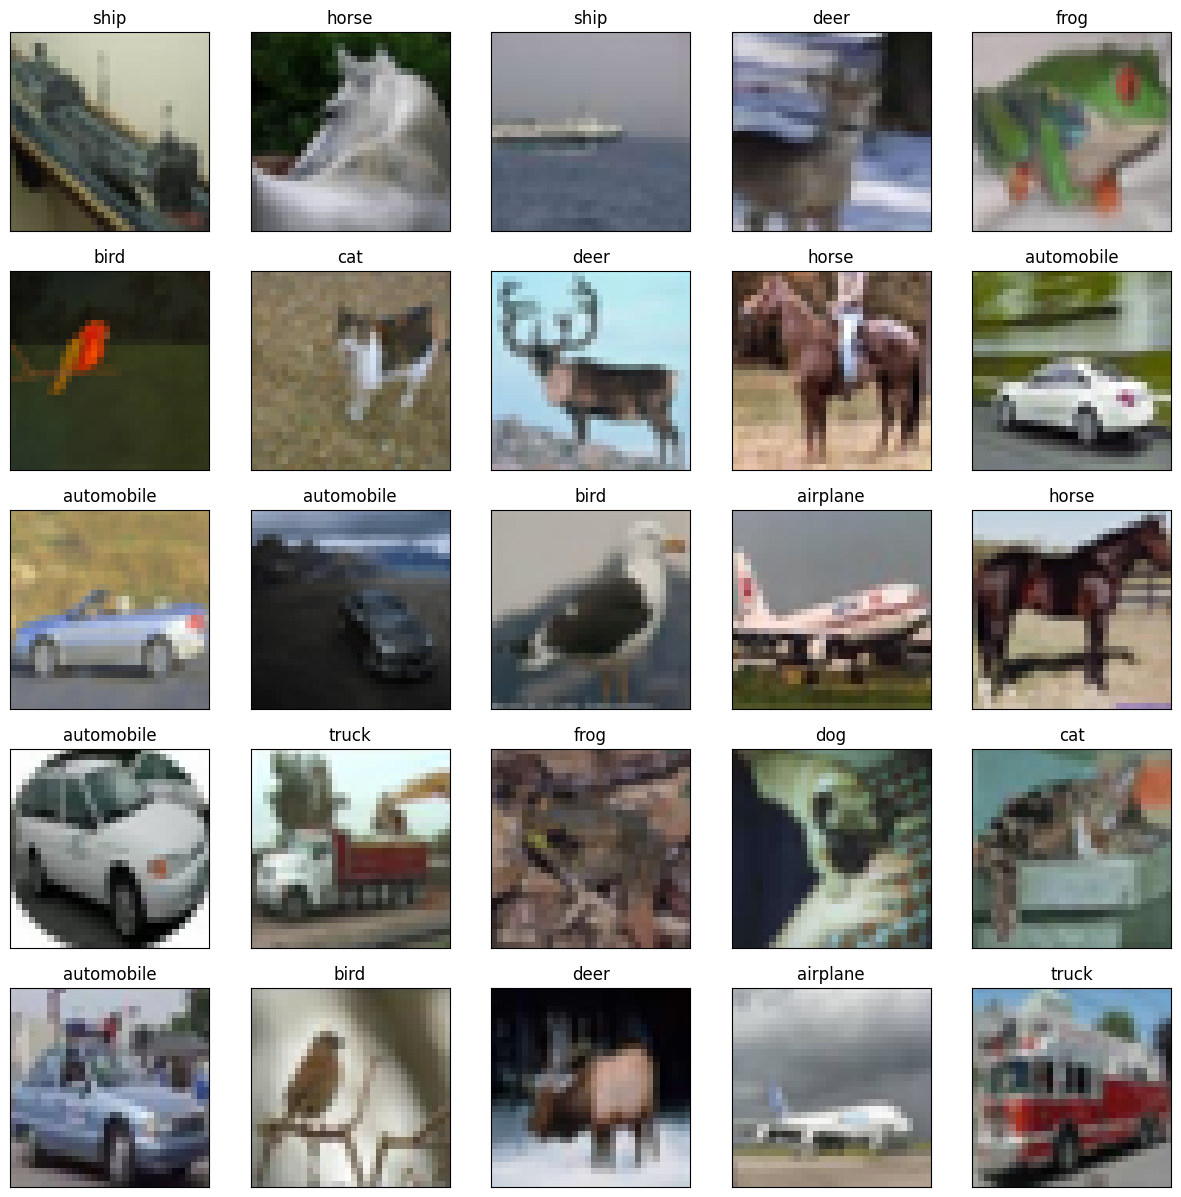

In [62]:
# CIFAR-10 classes
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
               
# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(25):
    # Create a subplot for each image
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Display the image
    plt.imshow(x_train[i])

    # Set the label as the title
    plt.title(cifar10_classes[y_train[i][0]], fontsize=12)

# Display the figure
plt.show()

In [63]:
# Convert pixel values data type to float32
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_valid = x_valid.astype('float32')

# Calculate the mean and standard deviation of the training images
mean = np.mean(x_train)
std  = np.std(x_train)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
x_train = (x_train-mean)/(std+1e-7)
x_test  = (x_test-mean) /(std+1e-7)
x_valid = (x_valid-mean)/(std+1e-7)

In [64]:
y_train= to_categorical(y_train,10)
y_valid= to_categorical(y_valid,10)
y_test = to_categorical(y_test,10)

In [66]:
data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.1,
    shear_range =10,  
    brightness_range=(0.5, 1.5),
    channel_shift_range=0.1,
    fill_mode = 'nearest'
)



In [67]:
nk_model = Sequential()

weight_decay = 0.0001  # Slightly reduced for better learning

# Block 1
nk_model.add(Conv2D(32, (3, 3), padding='same', activation='relu', 
                    kernel_regularizer=l2(weight_decay), input_shape=x_train.shape[1:]))
nk_model.add(BatchNormalization())
nk_model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
nk_model.add(BatchNormalization())
nk_model.add(MaxPooling2D(pool_size=(2, 2)))
nk_model.add(Dropout(0.25))

# Block 2
nk_model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
nk_model.add(BatchNormalization())
nk_model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
nk_model.add(BatchNormalization())
nk_model.add(MaxPooling2D(pool_size=(2, 2)))
nk_model.add(Dropout(0.3))

# Block 3
nk_model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
nk_model.add(BatchNormalization())
nk_model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
nk_model.add(BatchNormalization())
nk_model.add(MaxPooling2D(pool_size=(2, 2)))
nk_model.add(Dropout(0.4))

# Block 4 (no need for deeper)
nk_model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
nk_model.add(BatchNormalization())
nk_model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
nk_model.add(BatchNormalization())
nk_model.add(MaxPooling2D(pool_size=(2, 2)))
nk_model.add(Dropout(0.5))


nk_model.add(Flatten())


# Output
nk_model.add(Dense(10, activation='softmax'))

In [68]:
nk_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_47 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,186,346 (4.53 MB)

 Trainable params: 1,184,426 (4.52 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [69]:
batch_size = 64

epochs = 300

optimizer = Adam(learning_rate=0.0001)

steps_per_epoch = x_train.shape[0] // batch_size

nk_model.compile(optimizer=optimizer,loss= 'categorical_crossentropy', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor= 0.5,patience=10,min_lr=0.00001)

stopping_early =EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

history = nk_model.fit(data_generator.flow(x_train,y_train, batch_size= batch_size), steps_per_epoch= steps_per_epoch,epochs=epochs,validation_data=(x_valid,y_valid), callbacks=[reduce_lr,stopping_early],verbose=2)

#saving model
nk_model.save('/Users/sunny/Desktop/Image_classification/cnn_model@1.h5')

#Indiaction after running 
print("The model is succesfully trained and saved!!")

Epoch 1/300
632/632 - 59s - 94ms/step - accuracy: 0.2188 - loss: 3.2347 - val_accuracy: 0.2660 - val_loss: 2.1612 - learning_rate: 1.0000e-04
Epoch 2/300
632/632 - 2s - 3ms/step - accuracy: 0.2656 - loss: 2.3678 - val_accuracy: 0.2642 - val_loss: 2.1612 - learning_rate: 1.0000e-04
Epoch 3/300
632/632 - 58s - 92ms/step - accuracy: 0.2982 - loss: 2.3874 - val_accuracy: 0.2862 - val_loss: 2.0955 - learning_rate: 1.0000e-04
Epoch 4/300
632/632 - 2s - 3ms/step - accuracy: 0.2969 - loss: 2.4174 - val_accuracy: 0.2862 - val_loss: 2.0925 - learning_rate: 1.0000e-04
Epoch 5/300
632/632 - 1920s - 3s/step - accuracy: 0.3430 - loss: 2.1250 - val_accuracy: 0.3344 - val_loss: 2.0037 - learning_rate: 1.0000e-04
Epoch 6/300
632/632 - 2s - 3ms/step - accuracy: 0.3750 - loss: 2.0684 - val_accuracy: 0.3356 - val_loss: 1.9943 - learning_rate: 1.0000e-04
Epoch 7/300
632/632 - 772s - 1s/step - accuracy: 0.3780 - loss: 1.9706 - val_accuracy: 0.3356 - val_loss: 2.0511 - learning_rate: 1.0000e-04
Epoch 8/300
6

The model is succesfully trained and saved!!


In [72]:
nk_model.save('/Users/sunny/Desktop/Image_classification/cnn2_model@2.keras')

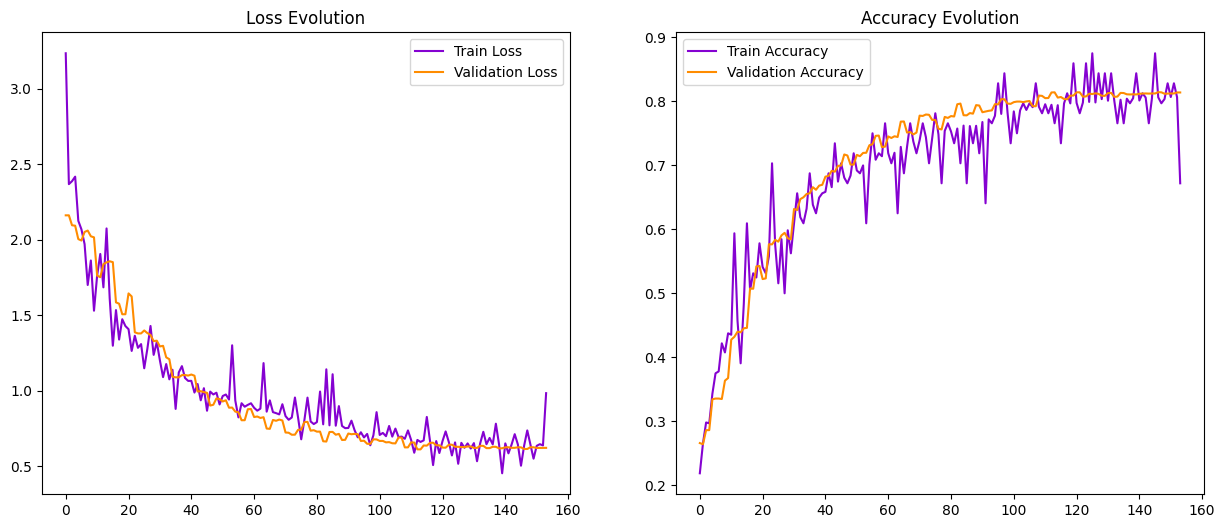

In [70]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(nk_model.history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(nk_model.history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(nk_model.history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(nk_model.history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

In [71]:
test_loss,test_acc = nk_model.evaluate(x_test,y_test,verbose=1)

print("\nLoss:", test_loss)
print("\nAcuuracy: ", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8220 - loss: 0.6162

Loss: 0.6229696869850159

Acuuracy:  0.8198000192642212
